<a href="https://colab.research.google.com/github/KoreTane/DCchallenge/blob/main/An%C3%A1lise_das_m%C3%A9tricas_RFV_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importação de bibliotecas para manipulação de dados
import pandas as pd
import numpy as np

# Importação de bibliotecas para visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Importação de bibliotecas para pré-processamento de dados
from sklearn.preprocessing import StandardScaler, scale
from sklearn.preprocessing import PowerTransformer

# Importação de bibliotecas para algoritmos de clusterização
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Importação de bibliotecas para visualização e avaliação de clusters
from yellowbrick.cluster import kelbow_visualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Carregamento e Pré-processamento dos Dados

Vamos incluir a coluna Total, pois, representa o valor monetário total gasto por um cliente em suas transações. Essa métrica é fundamental para a análise RFM, pois permite identificar clientes que geram mais receita.


In [ ]:
df = pd.read_csv('data.csv', sep = ',', encoding='latin-1')
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

In [ ]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
# vamos dropar os valores nulos na identificação do cliente
df = df.dropna(subset=['CustomerID'])
# Calcular o total da compra
df['Total'] = df['Quantity'] * df['UnitPrice']
# Converter as variáveis
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')
df['CustomerID'] = df['CustomerID'].astype(int)
df['Country'] = df['Country'].astype('category')
df.info()

# Exploração e Preparação dos Dados

Identificamos e removemos os outliers com foco:

Cliente Médio
Visando concentrar a análise nas transações que refletem o comportamento do cliente médio, garantindo que apenas compras representativas sejam consideradas e evitando extremos que possam distorcer os resultados.

Evitar Outliers
Outliers podem afetar negativamente a clusterização, criando grupos não representativos e distorcendo métricas como média e variância. A filtragem minimiza a influência desses outliers, permitindo que o modelo identifique padrões mais significativos nos dados.

Impacto Mínimo no Conjunto de Dados
A filtragem impacta menos de 5% do DataFrame, o que significa que a maioria das transações permanece inalterada. Isso assegura que a análise continue robusta e preserva uma quantidade significativa de dados, melhorando a qualidade da análise.

As variáveis mais relevantes para um modelo de clusterização baseado em RFM são InvoiceNo, Quantity, InvoiceDate, UnitPrice e CustomerID, essenciais para segmentar clientes. StockCode e Description têm baixa relevância, enquanto Country pode ser moderadamente relevante, dependendo do contexto.



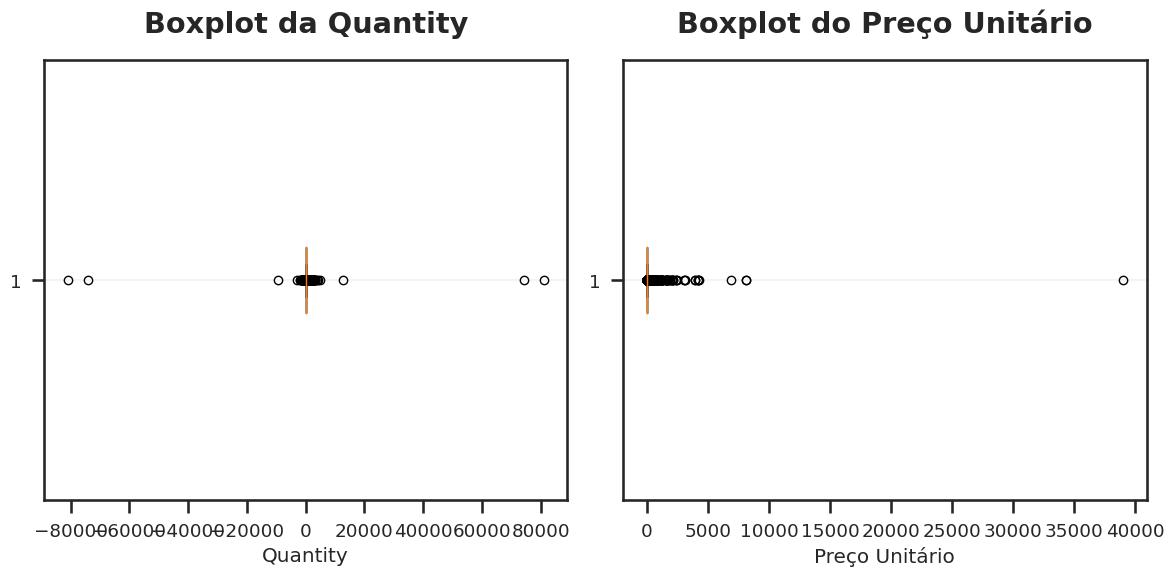

In [ ]:
# Criar uma figura com 1 linha e 2 colunas
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot para Quantity
axs[0].boxplot(df['Quantity'].dropna(), vert=False)
axs[0].set_title('Boxplot da Quantity')
axs[0].set_xlabel('Quantity')
axs[0].grid(axis='x')

# Boxplot para UnitPrice
axs[1].boxplot(df['UnitPrice'].dropna(), vert=False)
axs[1].set_title('Boxplot do Preço Unitário')
axs[1].set_xlabel('Preço Unitário')
axs[1].grid(axis='x')

# Ajustar o layout
plt.tight_layout()
plt.show()

In [ ]:
# Exibir as linhas filtradas para identificar a volumetria e qualidade dos dados
df[df['UnitPrice'] > 20]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom,-27.50
246,536392,22827,RUSTIC SEVENTEEN DRAWER SIDEBOARD,1,2010-12-01 10:29:00,165.00,13705,United Kingdom,165.00
294,536396,22803,IVORY EMBROIDERED QUILT,2,2010-12-01 10:51:00,35.75,17850,United Kingdom,71.50
431,536406,22803,IVORY EMBROIDERED QUILT,2,2010-12-01 11:33:00,35.75,17850,United Kingdom,71.50
1423,536540,C2,CARRIAGE,1,2010-12-01 14:05:00,50.00,14911,EIRE,50.00
...,...,...,...,...,...,...,...,...,...
535048,581182,POST,POSTAGE,4,2011-12-07 15:56:00,28.00,12783,Portugal,112.00
536968,581232,POST,POSTAGE,4,2011-12-08 10:26:00,40.00,12358,Austria,160.00
538070,581395,23485,BOTANICAL GARDENS WALL CLOCK,1,2011-12-08 13:18:00,25.00,16892,United Kingdom,25.00
539888,581449,23485,BOTANICAL GARDENS WALL CLOCK,1,2011-12-08 17:37:00,25.00,12748,United Kingdom,25.00


In [ ]:

df[df['Quantity'] > 200]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
181,536387,22466,FAIRY TALE COTTAGE NIGHTLIGHT,432,2010-12-01 09:58:00,1.45,16029,United Kingdom,626.4
182,536387,21731,RED TOADSTOOL LED NIGHT LIGHT,432,2010-12-01 09:58:00,1.25,16029,United Kingdom,540.0
219,536390,20668,DISCO BALL CHRISTMAS DECORATION,288,2010-12-01 10:19:00,0.10,17511,United Kingdom,28.8
730,536437,17021,NAMASTE SWAGAT INCENSE,600,2010-12-01 12:12:00,0.24,13694,United Kingdom,144.0
870,536477,21137,BLACK RECORD COVER FRAME,480,2010-12-01 12:27:00,3.39,16210,United Kingdom,1627.2
...,...,...,...,...,...,...,...,...,...
540062,581457,82484,WOOD BLACK BOARD ANT WHITE FINISH,204,2011-12-08 18:43:00,4.80,18102,United Kingdom,979.2
540070,581458,22197,POPCORN HOLDER,1500,2011-12-08 18:45:00,0.72,17949,United Kingdom,1080.0
540071,581459,22197,POPCORN HOLDER,1200,2011-12-08 18:46:00,0.72,17949,United Kingdom,864.0
540342,581476,16008,SMALL FOLDING SCISSOR(POINTED EDGE),240,2011-12-09 08:48:00,0.12,12433,Norway,28.8


In [ ]:
# Contar os valores que atendem aos critérios
count_filtered = df.query('UnitPrice >= 0 & UnitPrice < 20 & Quantity >= 0 & Quantity < 100').shape[0]

# Contar os valores que não atendem aos critérios
count_not_filtered = df.query('~(UnitPrice >= 0 & UnitPrice < 20 & Quantity >= 0 & Quantity < 100)').shape[0]

# Calcular a porcentagem de valores que não atendem em relação aos que atendem
percentage_not_filtered = (count_not_filtered / count_filtered) * 100 if count_filtered > 0 else 0

# Exibir o resultado( percebemos que itens acima de 20 reais na maioria das vezes não é um produto e também que não é frequente compras em grandes quantidades)
percentage_not_filtered

4.225334071159207

In [ ]:
# Vamos ajustar para pegar as transações do perfil do cliente médio
df = df.query('UnitPrice >= 0 & UnitPrice < 20 & Quantity >= 0 & Quantity < 100')

In [ ]:
print(df['UnitPrice'].describe())

count    390336.000000
mean          2.830547
std           2.795410
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max          19.960000
Name: UnitPrice, dtype: float64


# RMF
A etapa RFM (Recency, Frequency, Monetary) é crucial para segmentar clientes com base em seu comportamento de compra.
Recency: Mede o tempo desde a última compra, indicando o engajamento do cliente.
Frequency: Refere-se à quantidade de compras realizadas, sinalizando lealdade.
Monetary: Representa o total gasto, ajudando a identificar clientes valiosos.
Essa análise permite identificar diferentes segmentos de clientes e personalizar campanhas de marketing, otimizando recursos e aumentando a eficácia das estratégias de retenção e aquisição.

In [ ]:
#verificando a nossas datas min e max
df.sort_values(by='InvoiceDate', ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680,France,14.85
541901,581587,22367,CHILDRENS APRON SPACEBOY DESIGN,8,2011-12-09 12:50:00,1.95,12680,France,15.60
541895,581587,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-12-09 12:50:00,1.65,12680,France,19.80
541896,581587,22555,PLASTERS IN TIN STRONGMAN,12,2011-12-09 12:50:00,1.65,12680,France,19.80
541897,581587,22728,ALARM CLOCK BAKELIKE PINK,4,2011-12-09 12:50:00,3.75,12680,France,15.00
...,...,...,...,...,...,...,...,...,...
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.50


In [ ]:
#data min 2010-12-01, data max 2011-12-09
pd.Timestamp('2012-01-01')

Timestamp('2012-01-01 00:00:00')

In [ ]:
# Agrupar o DataFrame 'df' pelo 'CustomerID' para calcular as métricas RFM
df_rfm = (
  df.groupby('CustomerID')
  .agg(
      R = ('InvoiceDate', lambda x: (pd.Timestamp('2012-01-01') - x.max()).days),
      # A recência é o número de dias desde a última compra até a data de referência (2012-01-01)
      F = ('InvoiceNo', 'nunique'),
      # A frequência é o número de faturas únicas para cada cliente
      M = ('Total', 'mean')
      # O valor monetário é a média do total gasto por cada cliente
  )
)

df_rfm

,R,F,M
CustomerID,,,
12347,24,7,22.433149
12348,97,4,52.192500
12349,40,1,19.966197
12350,332,1,18.400000
12352,58,7,17.996623
...,...,...,...
18280,299,1,18.060000
18281,202,1,11.545714
18282,29,2,14.837500


<Axes: >

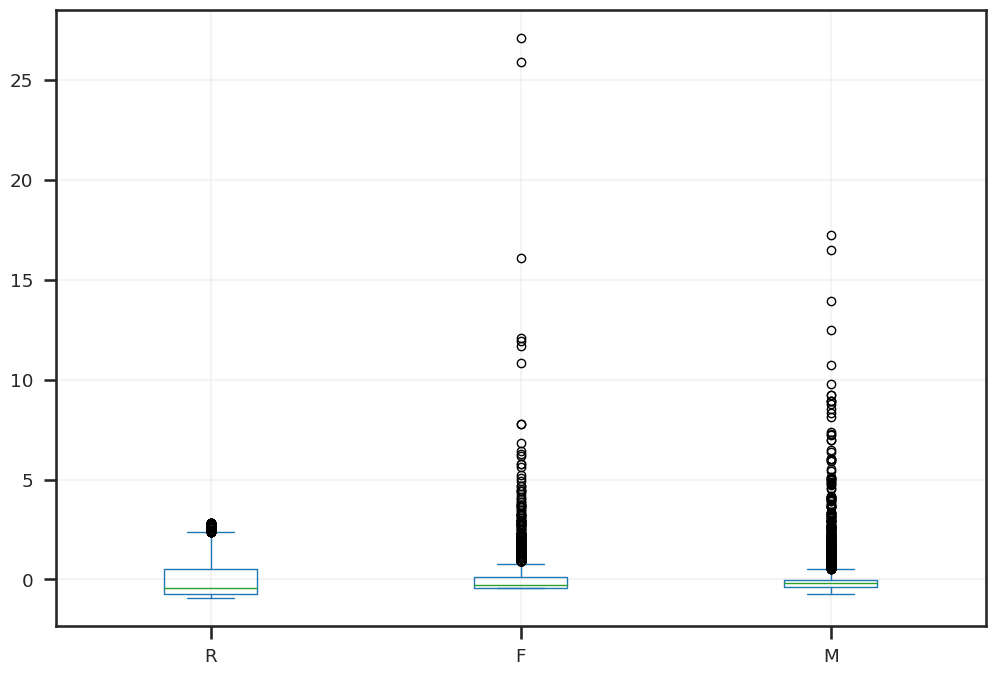

In [ ]:
df_rfm.apply(scale).plot.box()

In [ ]:
df_rfm.apply(scale).query('F>20')

,R,F,M
CustomerID,,,
12748,-0.920454,27.124633,-0.548211
14911,-0.910464,25.915002,-0.021649


In [ ]:
# Inicializa o transformador de potência para normalizar os dados
scaler = PowerTransformer()

In [ ]:
# Aplica a transformação de potência aos dados RFM para normalização e cria um novo DataFrame com os dados escalonados
df_rfm_scaled = pd.DataFrame(scaler.fit_transform(df_rfm), index=df_rfm.index, columns=df_rfm.columns)
df_rfm_scaled

,R,F,M
CustomerID,,,
12347,-1.563694,1.213999,0.438611
12348,0.323318,0.673263,1.487530
12349,-0.809153,-1.151484,0.284557
12350,1.566793,-1.151484,0.175280
12352,-0.307666,1.213999,0.145455
...,...,...,...
18280,1.474150,-1.151484,0.150190
18281,1.106437,-1.151484,-0.466041
18282,-1.275300,-0.184779,-0.117266


<Axes: >

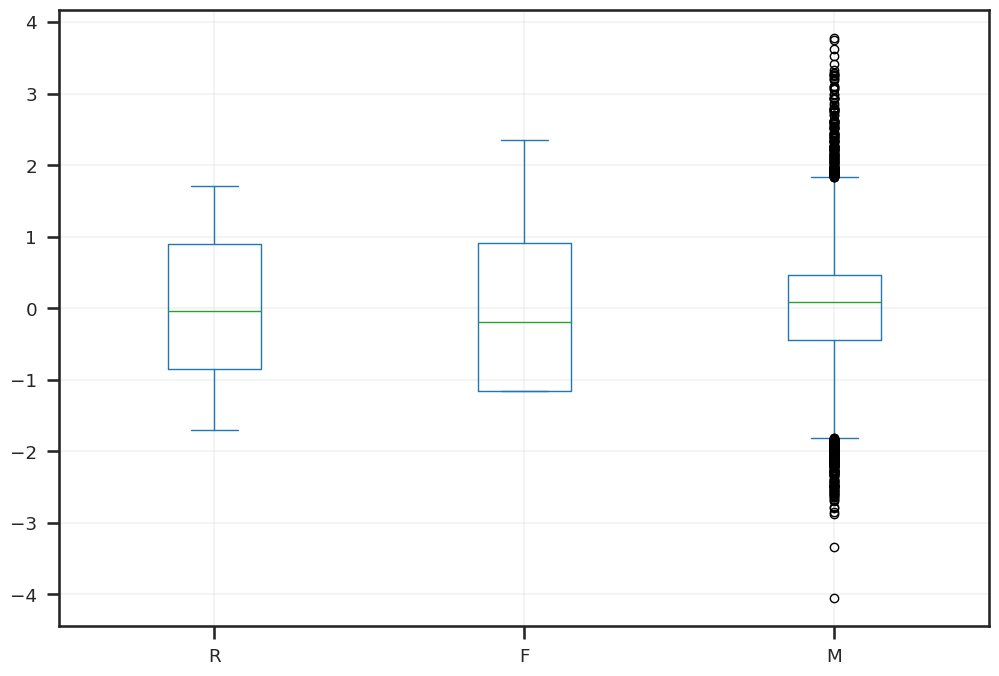

In [ ]:
#percebemos que ficaram menos dispersos
df_rfm_scaled.plot.box()

In [ ]:
# retornando os valores ao seu formato original
original_values = scaler.inverse_transform(df_rfm_scaled)

In [ ]:
# Limita os valores ao 95º percentil e escala os dados resultantes
df_rfm_clip = df_rfm.apply(lambda x: x.clip(upper=x.quantile(.95)))
df_rfm_clip_scaled = df_rfm_clip.apply(scale)
df_rfm_clip.describe()

,R,F,M
count,4280.000000,4280.000000,4280.000000
mean,112.344626,3.577336,20.252434
std,95.629786,3.331649,14.252364
min,22.000000,1.000000,0.747143
25%,39.000000,1.000000,11.691306
50%,72.000000,2.000000,17.200970
75%,164.250000,5.000000,22.874108
max,333.000000,13.000000,63.076915


In [ ]:
df_rfm.describe()

,R,F,M
count,4280.000000,4280.000000,4280.000000
mean,114.139486,4.185047,23.240147
std,100.113901,7.441153,30.607977
min,22.000000,1.000000,0.747143
25%,39.000000,1.000000,11.691306
50%,72.000000,2.000000,17.200970
75%,164.250000,5.000000,22.874108
max,395.000000,206.000000,550.800000


#Modelo Kmeans
Escolhemos o K-Means para a clusterização de clientes devido à sua simplicidade e eficiência. O algoritmo gera grupos bem definidos, facilitando a identificação de padrões de comportamento, e permite flexibilidade na definição do número de clusters. Isso torna o K-Means uma ferramenta prática e eficaz para segmentar clientes e personalizar estratégias de marketing.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

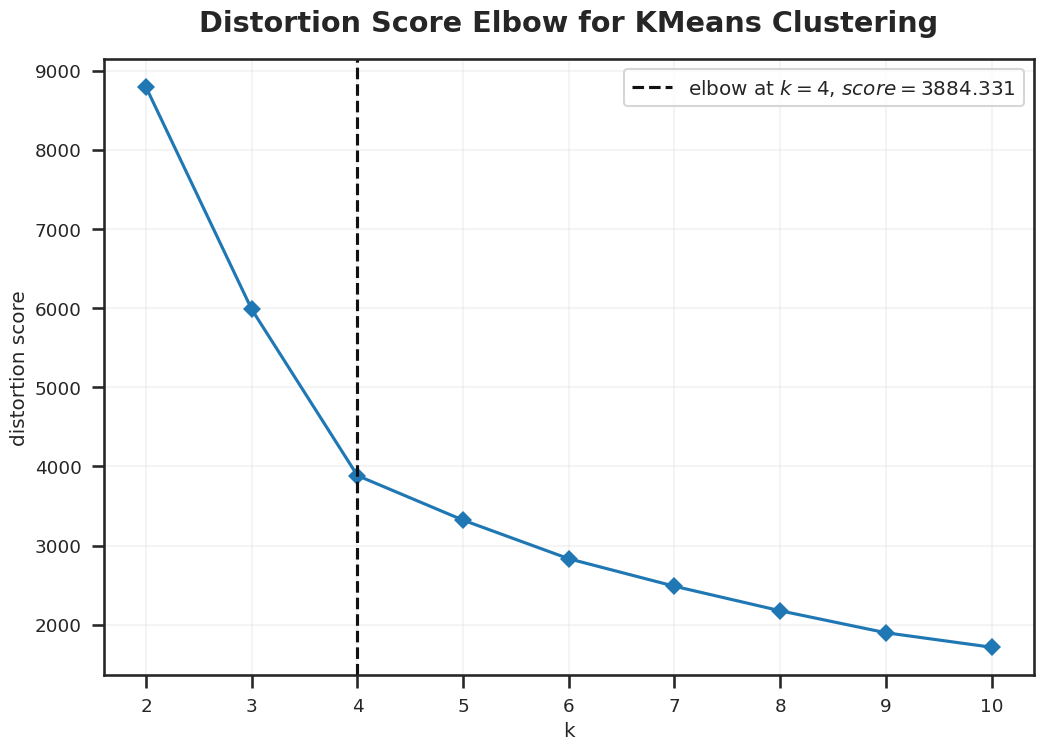

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [ ]:
# Identificando o número ideal de clusters. O método do "cotovelo" (elbow method) plota a soma das distâncias quadráticas
kelbow_visualizer(KMeans(), df_rfm_clip_scaled, k=10, timings=False)

In [ ]:
# Cria uma lista de funções de métricas de avaliação de clusters
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Inicializa uma lista para armazenar os resultados das métricas de cluster
cluster_metrics_results = []

# Cria uma cópia dos dados escalonados para uso no modelo K-Means
X = df_rfm_clip_scaled.copy()

# Loop para testar diferentes números de clusters (k) de 2 a 10
for k in range(2, 11):
    # Cria e ajusta o modelo K-Means com o número atual de clusters
    model = KMeans(n_clusters=k, random_state=0)
    labels = model.fit_predict(X)  # Faz a previsão dos rótulos dos clusters

    # Cria um dicionário para armazenar os resultados do cluster atual
    cluster_results_dict = {'k': k}
    cluster_results_dict['inertia'] = model.inertia_  # Armazena a inércia do modelo

    # Calcula e armazena as métricas de avaliação para o modelo atual
    for metric in cluster_metrics:
        cluster_results_dict[metric.__name__] = metric(X, labels)  # Avalia cada métrica e armazena no dicionário

    # Adiciona os resultados do dicionário à lista de resultados
    cluster_metrics_results.append(cluster_results_dict)

# Cria um DataFrame a partir dos resultados das métricas de cluster,
# define 'k' como índice e aplica um gradiente de fundo para melhor visualização
pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,8792.483830,0.368373,1.083848,1969.328149
3,5984.882382,0.411080,0.965664,2449.449812
4,3884.332037,0.454803,0.753745,3286.230927
5,3329.545057,0.449613,0.778746,3052.779541
6,2833.246922,0.370918,0.904265,3019.114133
7,2491.389757,0.350845,0.913334,2958.211344
8,2179.539608,0.349899,0.896828,2985.118936
9,1896.224468,0.342155,0.912323,3081.202322
10,1715.078358,0.346258,0.902788,3077.510450


In [ ]:
# Cria uma instância do modelo K-Means com 5 clusters, ajusta o modelo K-Means aos dados escalonados e faz a previsão dos rótulos dos clusters para cada ponto de dados
kmeans = KMeans(5)
kmeans_labels = kmeans.fit_predict(df_rfm_clip_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
# gráfico de dispersão 3D usando Plotly, plotando as métricas R, F e M,
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=kmeans_labels.astype(str), template='plotly_dark')

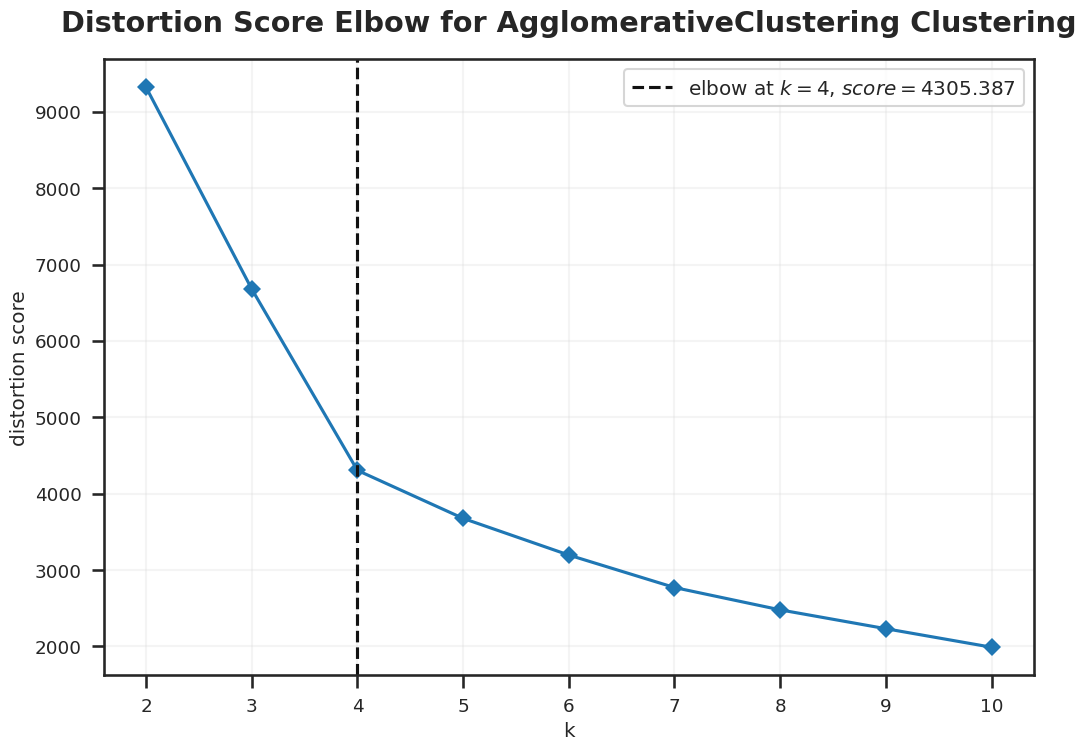

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(n_clusters=10),
                 timings=False)

In [ ]:
# testando a clusterização hierárquica aglomerativa,
kelbow_visualizer(AgglomerativeClustering(), df_rfm_clip_scaled, k=10, timings=False)

In [ ]:
# clusterização hierárquica aglomerativa, as métricas indicam que 4 é o número ideal de clusters
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfm_clip_scaled.copy()

for k in range(2,11):
  model = AgglomerativeClustering(n_clusters=k)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}

  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()
#Silhouette Score: 0.439010 (relativamente alto, indicando clusters bem definidos)
#Davies-Bouldin Score: 0.754092 (baixo, indicando clusters distintos)
#Calinski-Harabasz Score: 2825.453305 (alto, indicando boa separação entre os clusters)

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.334862,1.006792,1615.303594
3,0.372550,0.915302,1972.552015
4,0.439010,0.754092,2825.453305
5,0.334540,0.931732,2663.239676
6,0.348306,0.849262,2578.250508
7,0.351238,0.927546,2586.687504
8,0.318749,0.997802,2549.967388
9,0.295324,1.044610,2536.002862
10,0.300269,1.002658,2586.108300


In [ ]:
# Cria uma instância do modelo de clusterização hierárquica aglomerativa com 4 clusters
hclust = AgglomerativeClustering(n_clusters=5)

# Ajusta o modelo aos dados escalonados 'df_rfm_clip_scaled' e faz a previsão dos rótulos dos clusters
hclust_labels = hclust.fit_predict(df_rfm_clip_scaled)

In [ ]:
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=hclust_labels.astype(str), template='plotly_dark')

## Gaussian Mixture

In [ ]:
# Inicializa uma lista vazia para armazenar os resultados da seleção do modelo
results = []

# Define o intervalo de valores para o número de componentes (k) a serem testados
k_range = range(1, 9)

# Define os tipos de covariância a serem testados no modelo GaussianMixture
covariance_types = ['full', 'tied', 'diag', 'spherical']

# Faz uma cópia dos dados escalonados para uso no modelo
X = df_rfm_clip_scaled.copy()

# Loop para testar diferentes combinações de número de componentes e tipos de covariância
for n_components in k_range:
    for covariance_type in covariance_types:
        # Cria uma instância do modelo GaussianMixture com o número atual de componentes e tipo de covariância
        mclust = GaussianMixture(n_components=n_components, n_init=10, warm_start=True, covariance_type=covariance_type)

        # Ajusta o modelo aos dados
        mclust.fit(X)

        # Adiciona os resultados do BIC, número de componentes e tipo de covariância à lista de resultados
        results.append({
            'bic': mclust.bic(X),  # Calcula o BIC do modelo ajustado
            'n_components': n_components,
            'covariance_type': covariance_type,
        })

# Converte a lista de resultados em um DataFrame do pandas
results = pd.DataFrame(results)

# Ordena os resultados pelo BIC e exibe as primeiras linhas do DataFrame
results.sort_values('bic').head()
#Com base no BIC, o modelo com 8 componentes e tipo de covariância diag é o mais adequado para os seus dados
#Este modelo oferece o melhor equilíbrio entre a complexidade do modelo e o ajuste aos dados.

,bic,n_components,covariance_type
30,-3169.533543,8,diag
26,-1621.882707,7,diag
28,1048.604217,8,full
24,1254.804856,7,full
20,2825.654836,6,full


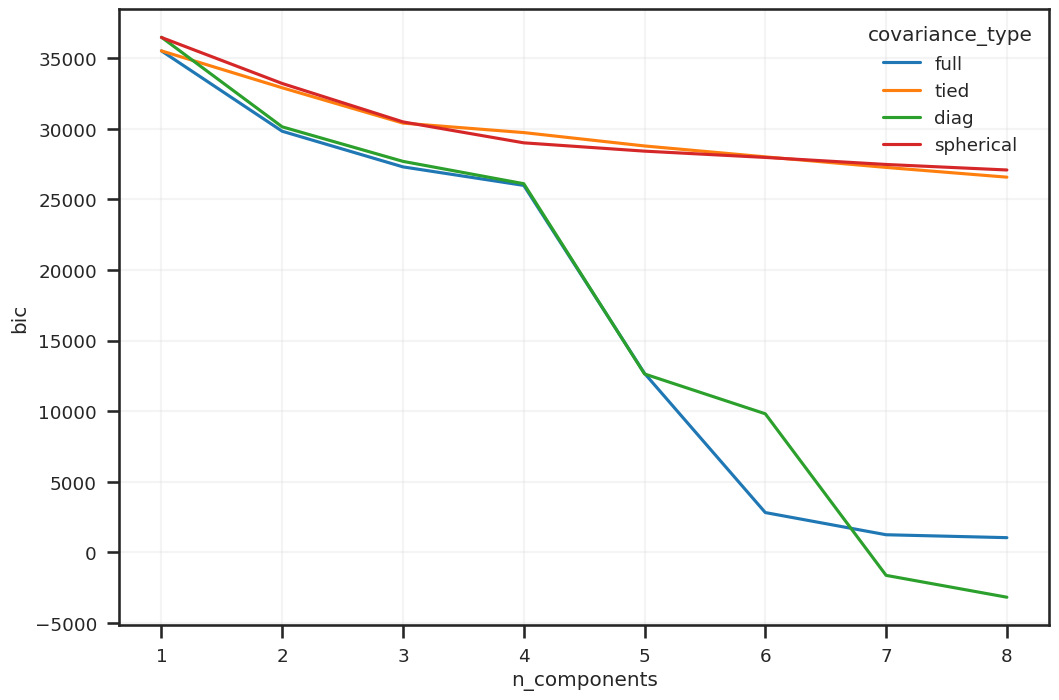

In [ ]:
# Cria um gráfico de linha usando Seaborn para visualizar a relação entre o número de componentes
sns.lineplot(data=results, x='n_components', y='bic', hue='covariance_type');
# o modeloindicado  de clusterização tem 8 grupos e usa a covariância “diag”, pois oferece o melhor equilíbrio entre precisão e simplicidade, conforme indicado pelo menor valor de BIC

In [ ]:
# Cria uma instância do modelo GaussianMixture com 5 componentes e tipo de covariância 'full'.
# O modelo é ajustado aos dados escalonados 'df_rfm_clip_scaled' e os rótulos dos clusters resultantes
# são armazenados na variável 'mclust_labels'.
mclust = GaussianMixture(n_components=5, covariance_type='full', n_init=10)
mclust_labels = mclust.fit_predict(df_rfm_clip_scaled)

In [ ]:
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=mclust_labels.astype(str), template='plotly_dark')

#Interpretando os Clusters

In [ ]:
# Cria um DataFrame com os centros dos clusters do K-Means
centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_rfm_clip_scaled.columns)

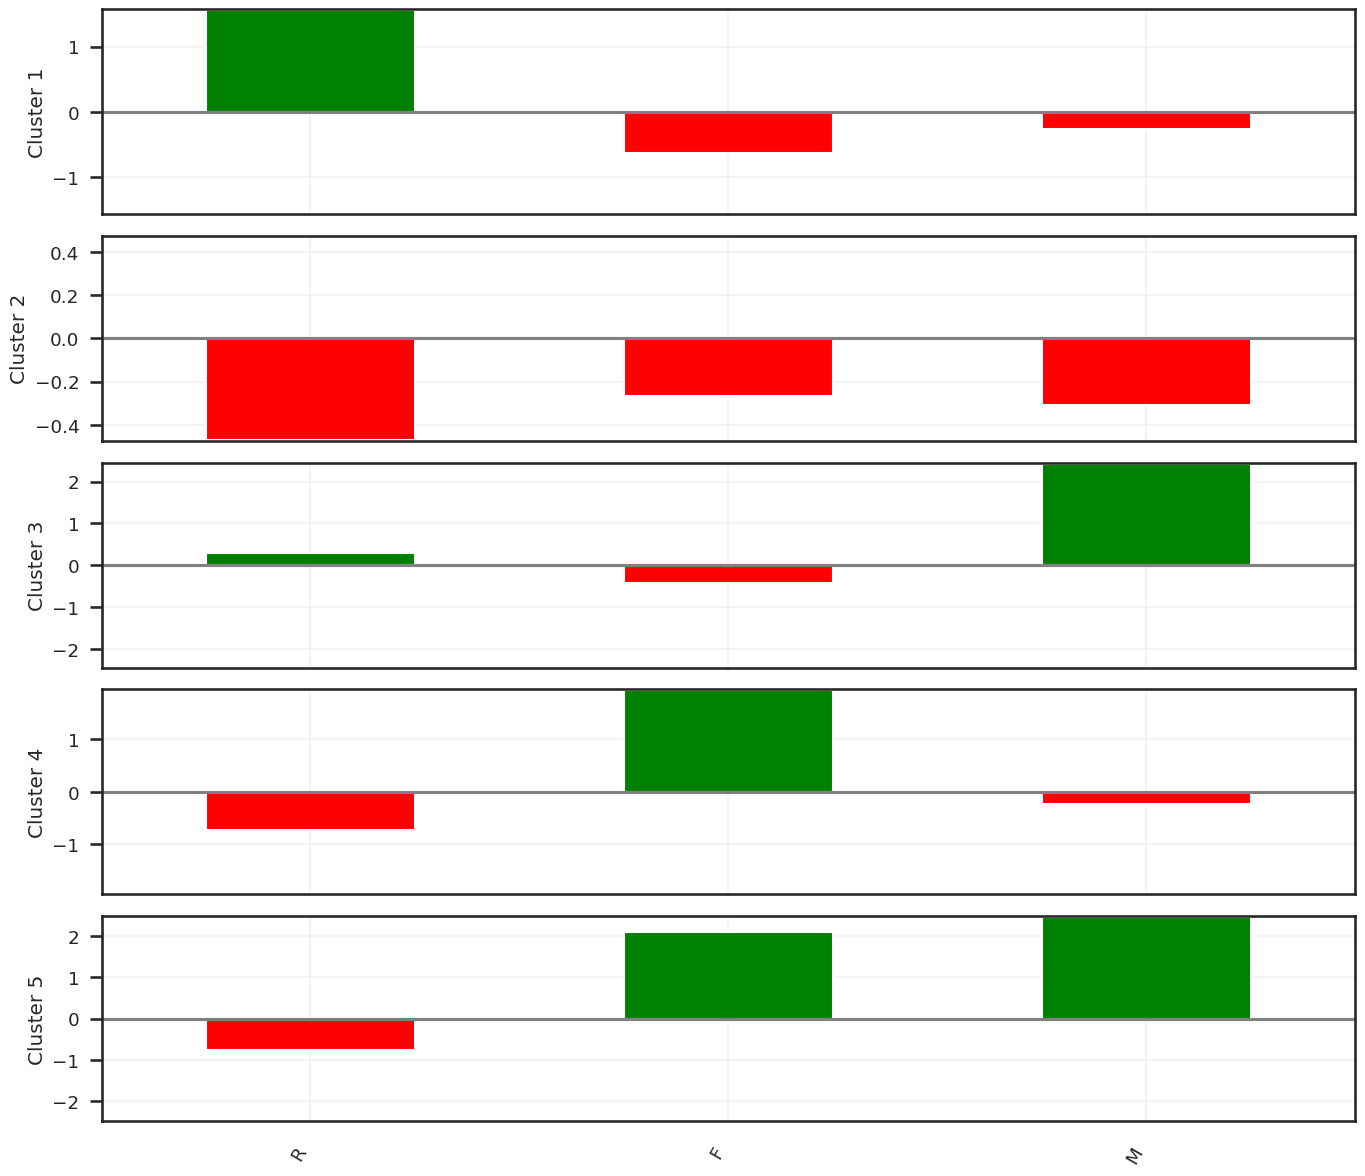

In [ ]:
# Adaptado do livro "Practical Statistics for Data Scientists"
fig,axes = plt.subplots(nrows=5, figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
(
  df_rfm_clip.assign(cluster=kmeans_labels)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='YlOrRd', axis=1)
)
Os resultados mostram a média dos valores de Recência ®, Frequência (F) e Monetário (M) para cada cluster, com uma escala de cores que vai do amarelo ao vermelho para indicar a magnitude dos valores.

#Cluster 0: Alta recência (261.31), baixa frequência (1.49), e baixo valor monetário (16.45).
#Cluster 1: Baixa recência (67.36), média frequência (2.68), e baixo valor monetário (15.86).
#Cluster 2: Média recência (141.06), média frequência (2.12), e alto valor monetário (54.89).
#Cluster 3: Baixa recência (42.43), alta frequência (10.04), e baixo valor monetário (16.95).
#Cluster 4: Baixa recência (40.55), alta frequência (10.56), e alto valor monetário (55.31).

cluster,0,1,2,3,4
R,261.311783,67.357360,141.055215,42.431338,40.548387
F,1.492179,2.682588,2.122699,10.035211,10.564516
M,16.453635,15.857531,54.894248,16.950147,55.308697


# Interpretação dos Clusters de Clientes

A seguir, apresentamos a interpretação técnica dos diferentes perfis de clientes identificados através da análise de clusterização no projeto. Embora o nosso modelo tenha sugerido 4 clusters como ideal, optamos por 5, pois conseguimos notar, através das análises, que existem 5 comportamentos distintos de consumo.

## Perfil Cliente 1
**Características**: Este grupo consiste em clientes que realizaram compras recentemente, mas com baixa frequência e valores baixos.  
**Implicações**: Esses clientes podem estar em fase de experimentação ou apenas realizando compras ocasionais. Estratégias de marketing focadas em promoções ou incentivos para aumentar a frequência de compras podem ser eficazes.

## Perfil Cliente 2
**Características**: Clientes deste perfil não compram recentemente, nem com frequência, e quando o fazem, os valores são baixos.  
**Implicações**: Este grupo pode indicar clientes inativos ou desengajados. A empresa deve considerar campanhas de reativação, como ofertas especiais ou lembretes, para incentivá-los a retornar.

## Perfil Cliente 3
**Características**: Compreende clientes que realizaram compras relativamente recentes, são muito frequentes e gastam valores altos.  
**Implicações**: Este é o perfil mais valioso, representando clientes leais e engajados. Estratégias de fidelização, como programas de recompensas ou acesso antecipado a novos produtos, podem ajudar a manter e aumentar esse relacionamento.

## Perfil Cliente 4
**Características**: Este grupo não compra recentemente, mas apresenta excelente frequência de compras com valores baixos.  
**Implicações**: Esses clientes podem ter um padrão de compra regular, mas com um ticket médio baixo. Estratégias para aumentar o valor das compras, como upselling ou cross-selling, podem ser eficazes.

## Perfil Cliente 5
**Características**: Clientes que não compram recentemente, mas têm alta frequência e gastam muito dinheiro.  
**Implicações**: Este perfil indica clientes que podem ter um histórico de compras altas, mas que se tornaram inativos recentemente. É importante implementar ações para reengajá-los, como ofertas personalizadas baseadas em suas compras anteriores.